
# Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a regression activity.

## Workflow
1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Data preparation, according to background information
    1. Set the __target__ variable, according to background information
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [262]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import pandas as pd
random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.csv` file and show a short description

In [263]:
dataset_url = "regression_example.csv"
target = "response"

df = pd.read_csv(dataset_url)
df.sample(10)

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
486,486,1.708511,1.402550,-0.249862,0.645089,1.775879,0.510895,-1.781401,-0.435183,-41.180563
499,499,1.159384,1.244553,-0.256624,0.111160,0.698756,-1.559714,1.465728,1.175598,71.507952
256,256,0.936575,0.340079,-1.531841,0.108796,0.614249,1.466914,0.437500,0.395094,-34.594366
285,285,-0.421006,-0.382522,-0.132325,0.158209,1.514089,-0.503909,-2.019381,0.307700,-107.801293
708,708,1.578841,0.345747,0.042349,0.128430,0.155503,1.192621,1.526015,0.045792,85.021366
404,404,-0.792444,-0.904343,0.328410,2.568489,0.092356,-0.727552,1.915133,-0.470609,275.562269
153,153,-0.759835,NaN,-0.282673,0.863427,1.545329,-0.456772,-0.090079,-0.455882,63.200363
215,215,0.023401,-0.935236,-1.384912,0.370915,0.396994,-0.703132,-0.622208,0.540613,-25.413491
2,2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
400,400,3.043062,-0.021696,0.944843,0.016002,-0.961658,0.338959,0.428667,-0.492136,68.590308


## Data Exploration and preparation

##### Show a short description of the columns

In [264]:
print(df.shape)
df.describe()


(843, 10)


,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
count,843.000000,802.000000,807.000000,812.000000,8.020000e+02,805.000000,808.000000,806.000000,812.000000,813.000000
mean,421.000000,-0.037473,0.008466,-0.059965,9.616777e-01,-0.093113,0.034653,-0.019928,-0.034976,3.798356
std,243.497433,1.038115,0.973884,0.991280,1.286476e+00,1.050385,0.957238,0.997345,0.963010,114.189124
min,0.000000,-3.700229,-2.832440,-4.141473,2.007427e-08,-4.072767,-2.968219,-2.850505,-3.948627,-358.659591
25%,210.500000,-0.723630,-0.640017,-0.681924,8.725649e-02,-0.802553,-0.625219,-0.689671,-0.662887,-73.823652
50%,421.000000,-0.032953,0.005693,-0.050789,4.707895e-01,-0.090512,0.051123,-0.014592,-0.049392,-0.159154
75%,631.500000,0.629368,0.681480,0.587393,1.350123e+00,0.611545,0.689203,0.612939,0.614423,75.487094
max,842.000000,3.043062,2.945731,2.925432,9.200073e+00,3.024952,3.210373,2.861549,3.000174,422.794685


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [265]:
df.shape[0] - df.dropna().shape[0]

273

#### Drop data that are useless or not usable

In [266]:
df = df.dropna()
df = df.drop("idx", axis=1)
df.shape

(570, 9)

In [267]:
df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,response
1,0.644764,0.007172,0.004493,4.168748,-0.622817,1.855366,-0.540468,1.141118,151.951717
2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
3,-0.212410,-1.034267,1.843441,4.486992,-0.610050,0.734101,-0.142660,-0.172119,229.358473
4,-0.827402,-2.048496,-0.066242,1.361695,1.268456,-1.084906,1.986556,0.425511,230.153189
5,-0.635465,-1.112850,-0.330580,6.141348,1.914527,0.408895,-0.364722,-0.731382,-261.116572


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [268]:
X = df.drop(target, axis=1) # nota che drop crea una copia di df, modificare X non modifica anche df
y = df[target]

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

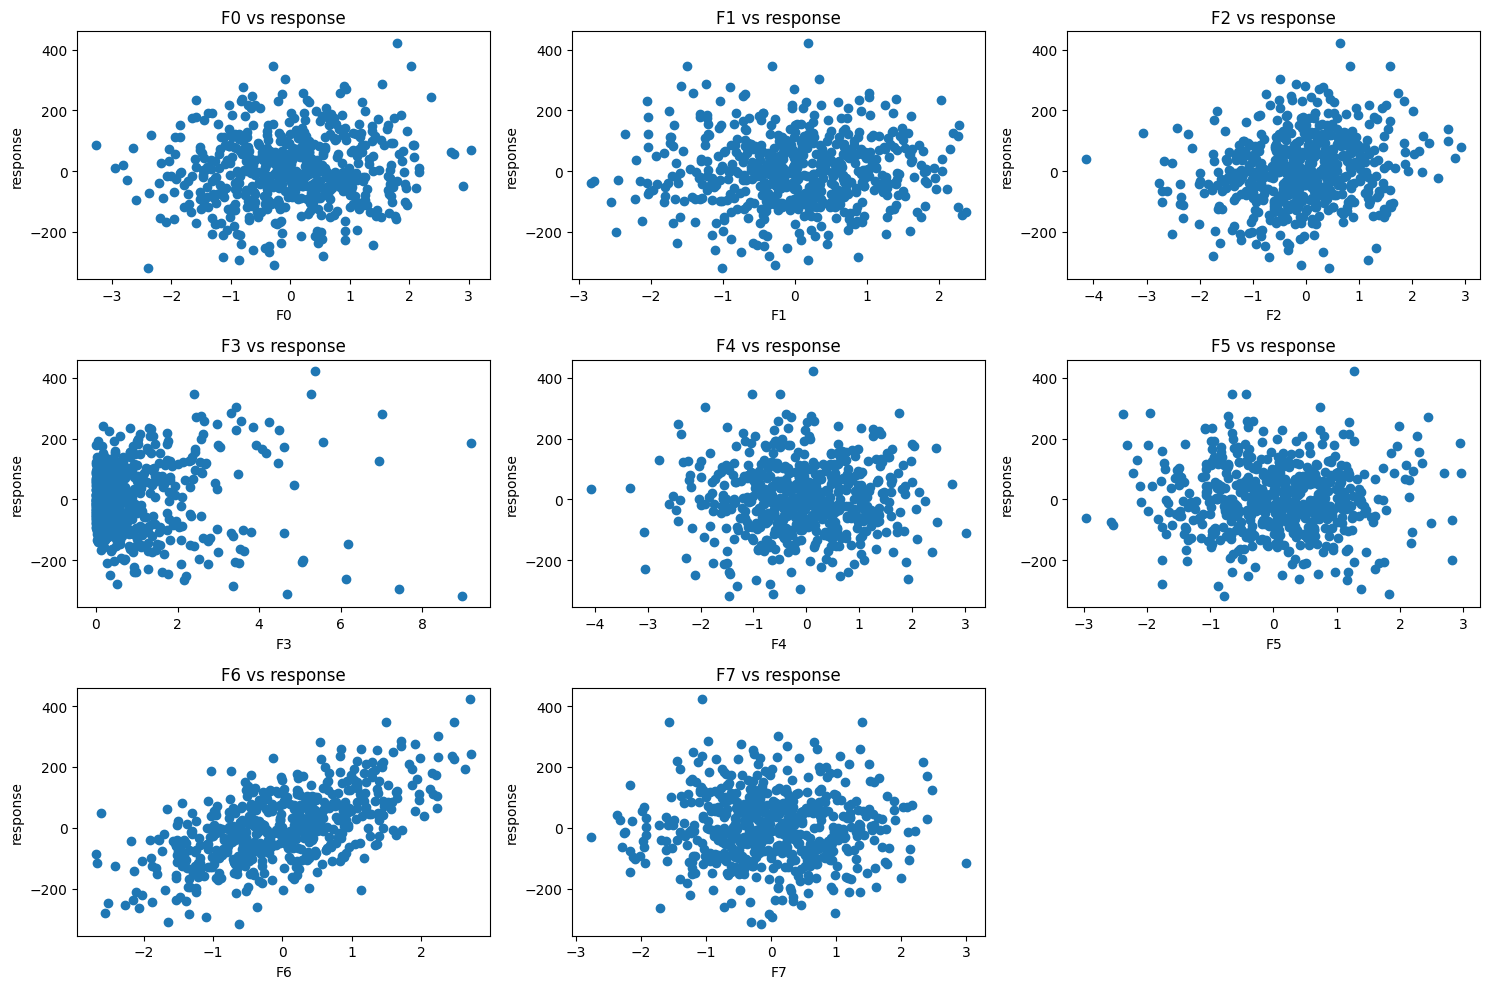

In [269]:
n = len(X.columns)
cols = 3
rows = (n + 2) // cols # approssimo per eccesso
plt.figure(figsize=(15, 10))

for i, feature in enumerate(X.columns, 1):
    plt.subplot(rows, cols, i)
    plt.scatter(X[feature], y)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f"{feature} vs {target}")

plt.tight_layout()
plt.show()


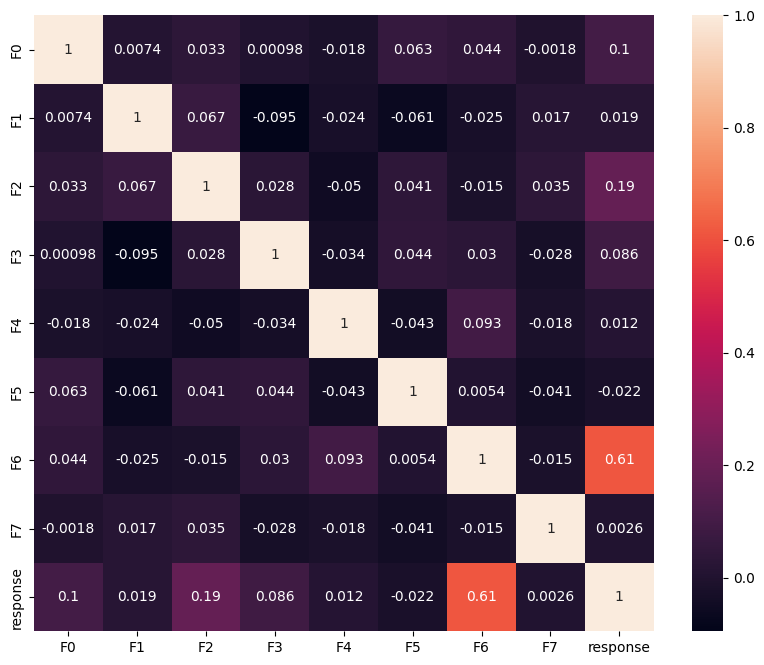

In [270]:
import seaborn as sns

corr_mat = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, annot=True)
plt.show() 

## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [271]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=random_state, test_size=0.3)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(399, 8) (171, 8) (399,) (171,)


## 2. First experiment - univariate linear regression
We choose the variable exhibiting the highest correlation with respect to the target

Consider a reduced dataset containing the chosen variable and the target

In [272]:
most_correlated = corr_mat[target].drop(target).abs().idxmax()
Xtrain_corr = Xtrain[[most_correlated]] # per ottenere un dataframe (che mi server per .fit()) devo usare le doppie [[
                                          # alternativamente costruisci una matrice con una colonna: Xtrain[most_correlated].values.reshape(-1,1)
Xtest_corr = Xtest[[most_correlated]]
Xtrain_corr

,F6
266,0.621024
466,1.296056
569,-0.842738
11,0.939110
439,-0.887748
...,...
259,-0.214038
242,0.642865
105,0.355984
700,-0.472870


### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [273]:
univariate_estimator = linear_model.LinearRegression().fit(Xtrain_corr, ytrain)
# parametri del modeunivariate_estimatorllo
weight_uni = univariate_estimator.coef_[0] # ho utilizzato solo una variabile e quindi ho solo un peso
intercept = univariate_estimator.intercept_
print(f"intercetta: {intercept}, peso: {weight_uni}")

ytrain_corr_pred = univariate_estimator.predict(Xtrain_corr)
ytest_corr_pred = univariate_estimator.predict(Xtest_corr)

intercetta: 0.8417896883365309, peso: 73.96616764309125


#### Compute the quality measures

In [274]:
results = pd.DataFrame(columns=["Model", "RMSE", "R_square"])

# from sklearn.metrics import mean_squared_error, r2_score

mse_train = mean_squared_error(ytrain, ytrain_corr_pred)
mse_test = mean_squared_error(ytest, ytest_corr_pred)
print(f"MSE train: {mse_train}, MSE test: {mse_test}")
r2_train = r2_score(ytrain, ytrain_corr_pred)
r2_test = r2_score(ytest, ytest_corr_pred)
print(f"R2 train: {r2_train}, R2 test: {r2_test}")

results.loc[len(results)] = ["Univariate", mse_test**0.5, r2_test]

MSE train: 8491.310672391159, MSE test: 7245.711320661929
R2 train: 0.3850898398866617, R2 test: 0.33847681347897574


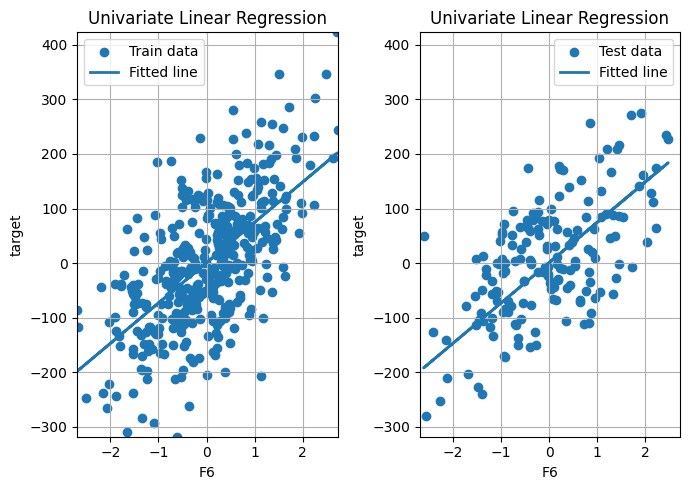

In [275]:
### Mostriamo anche il modello

import matplotlib.pyplot as plt
import numpy as np

# estraggo X e y come array
x_train = Xtrain_corr[most_correlated]
x_test = Xtest_corr[most_correlated]

plt.figure(figsize=(7,5))
# calcolo il range comune
xmin = min(x_train.min(), x_test.min())
xmax = max(x_train.max(), x_test.max())
ymin = min(ytrain.min(), ytest.min())
ymax = max(ytrain.max(), ytest.max())

plt.subplot(1, 2, 1)
# scatter dati reali
plt.scatter(x_train, ytrain, label="Train data")
# retta di regressione
plt.plot(x_train, ytrain_corr_pred, linewidth=2, label="Fitted line")
plt.xlabel(most_correlated)
plt.ylabel("target")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title("Univariate Linear Regression")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# scatter dati reali
plt.scatter(x_test, ytest, label="Test data")
# retta di regressione
plt.plot(x_test, ytest_corr_pred, linewidth=2, label="Fitted line")
plt.xlabel(most_correlated)
plt.ylabel("target")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title("Univariate Linear Regression")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [276]:
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=random_state, test_size=0.3)
# print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

In [277]:
multivariate_estimator = linear_model.LinearRegression().fit(Xtrain, ytrain)
# parametri del modello
weights = multivariate_estimator.coef_
intercept = multivariate_estimator.intercept_

weight_df = pd.DataFrame(columns=["Variable", "Coefficient"])

for idx, feature in enumerate(Xtrain.columns):
    weight_df.loc[len(weight_df)] = [feature, weights[idx]]

print(weight_df)
print(f"Intercetta: {intercept}")

ytrain_pred = multivariate_estimator.predict(Xtrain)
ytest_pred = multivariate_estimator.predict(Xtest)

  Variable  Coefficient
0       F0     9.225329
1       F1     2.794846
2       F2    21.766171
3       F3     3.299594
4       F4    -5.532386
5       F5    -6.002884
6       F6    72.949625
7       F7    -2.675824
Intercetta: -0.6174494765006131


#### Compute the quality measures

In [278]:
mse_train = mean_squared_error(ytrain, ytrain_pred)
mse_test = mean_squared_error(ytest, ytest_pred)
print(f"MSE train: {mse_train}, MSE test: {mse_test}")
r2_train = r2_score(ytrain, ytrain_pred)
r2_test = r2_score(ytest, ytest_pred)
print(f"R2 train: {r2_train}, R2 test: {r2_test}")

results.loc[len(results)] = ["Multivariate", mse_test**0.5, r2_test]
results

MSE train: 7857.973809556282, MSE test: 6577.886025358827
R2 train: 0.4309538162216372, R2 test: 0.3994483175642217


,Model,RMSE,R_square
0,Univariate,85.121744,0.338477
1,Multivariate,81.104168,0.399448


## Decision Tree Multivariate Regresson

In [279]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor 
# a quanto pare la regression line di questo DecisionTreeRegressor è una composizione di linee

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

In [280]:
dt = DecisionTreeRegressor(random_state=random_state)
dt.fit(Xtrain, ytrain)
print(f"max depth del full dt-regressor: {dt.tree_.max_depth}")

max depth del full dt-regressor: 22


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

In [281]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": list(range(1, dt.tree_.max_depth+1)) # ricordiamoci che range non include l'estremo destro
}

dt_gscv = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=random_state),
    param_grid=param_grid,
    scoring="neg_mean_squared_error" # NB: grid search cerca di massimizzare gli score, ma MSE va minimizzato, quindi consideriamo la sua versione negativa
)

dt_gscv.fit(Xtrain, ytrain)
dt_best = dt_gscv.best_estimator_
dt_best_depth = dt_best.tree_.max_depth

print(f"The optimal maximum depth for the decision tree is {dt_best_depth}")


The optimal maximum depth for the decision tree is 2


In [282]:
ytest_pred = dt_best.predict(Xtest)

mse_test = mean_squared_error(ytest, ytest_pred)
print(f"MSE test: {mse_test}")
print(f"RMSE: {mse_test**0.5}")
r2_test = r2_score(ytest, ytest_pred)
print(f"R2 test: {r2_test}")

results.loc[len(results)] = ["DT Multivariate", mse_test**0.5, r2_test]
results

MSE test: 8068.927228046387
RMSE: 89.82720761576854
R2 test: 0.26331836648221985


,Model,RMSE,R_square
0,Univariate,85.121744,0.338477
1,Multivariate,81.104168,0.399448
2,DT Multivariate,89.827208,0.263318


#### Show the tree

[Text(0.5, 0.8333333333333334, 'x[6] <= 0.493\nsquared_error = 13809.026\nsamples = 399\nvalue = 0.479'),
 Text(0.25, 0.5, 'x[6] <= -1.071\nsquared_error = 9807.563\nsamples = 282\nvalue = -38.248'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'squared_error = 8030.323\nsamples = 57\nvalue = -115.58'),
 Text(0.375, 0.16666666666666666, 'squared_error = 8359.033\nsamples = 225\nvalue = -18.658'),
 Text(0.75, 0.5, 'x[6] <= 1.68\nsquared_error = 11125.64\nsamples = 117\nvalue = 93.823'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'squared_error = 8971.137\nsamples = 102\nvalue = 76.235'),
 Text(0.875, 0.16666666666666666, 'squared_error = 9369.573\nsamples = 15\nvalue = 213.419')]

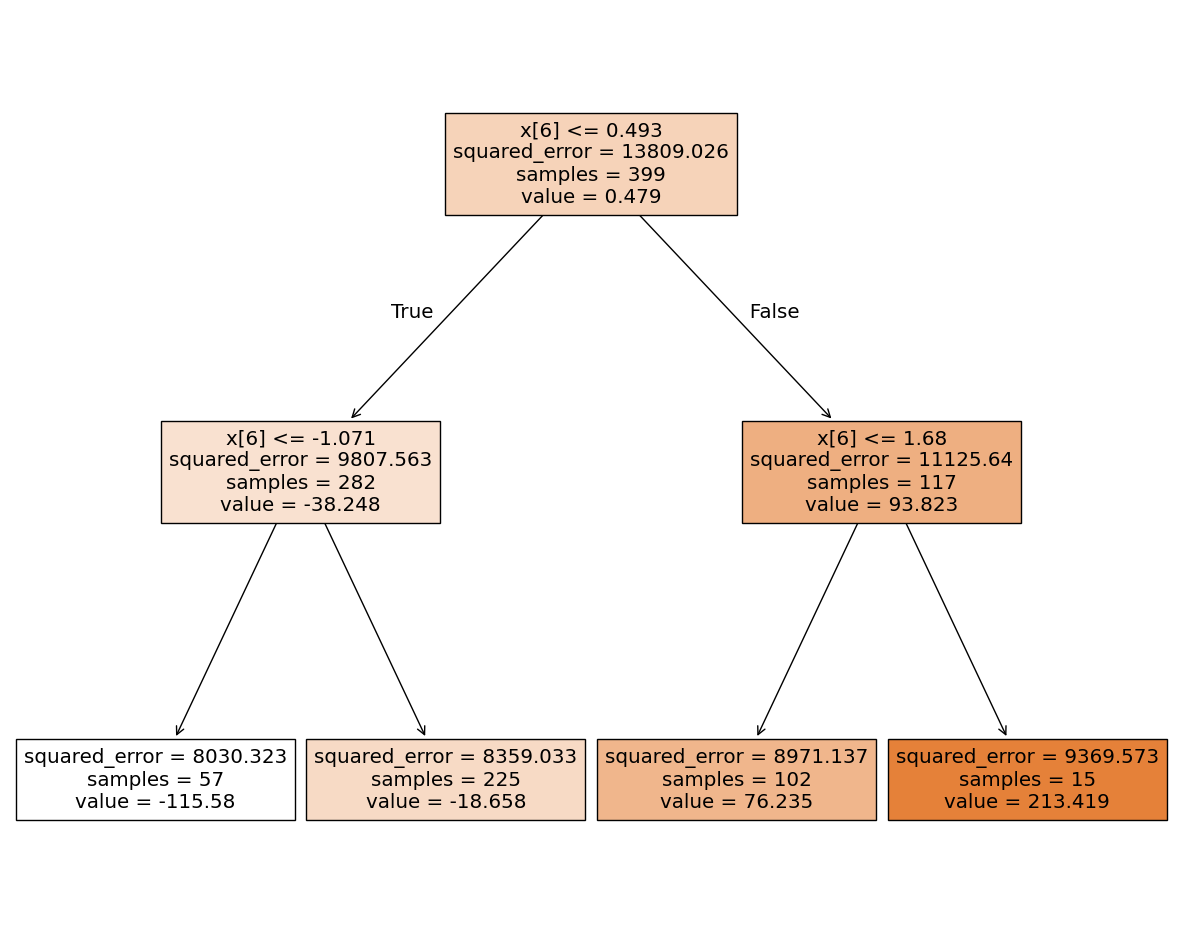

In [283]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure

plt.figure(figsize=(15,12))

plot_tree(
    dt_best,
    filled=True
)

## Random Forest Multivariate Regresson

In [284]:
# Create Random Forest regression object
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=random_state)

param_grid = {
    "max_depth": list(range(1, dt.tree_.max_depth+1)) # ricordiamoci che range non include l'estremo destro
}

rf_gscv = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error" # NB: grid search cerca di massimizzare gli score, ma MSE va minimizzato, quindi consideriamo la sua versione negativa
)

rf_gscv.fit(Xtrain, ytrain)
rf_best = rf_gscv.best_estimator_
rf_best_depth = rf_best.max_depth

In [285]:
print(f"The optimal maximum depth for the trees in the random forest is 3 {rf_best_depth}")

The optimal maximum depth for the trees in the random forest is 3 3


In [286]:
ytest_pred = rf_best.predict(Xtest)

mse_test = mean_squared_error(ytest, ytest_pred)
print(f"MSE test: {mse_test}")
print(f"RMSE: {mse_test**0.5}")
r2_test = r2_score(ytest, ytest_pred)
print(f"R2 test: {r2_test}")

results.loc[len(results)] = ["RF Multivariate", mse_test**0.5, r2_test]
results

MSE test: 7174.29908202018
RMSE: 84.70123424142166
R2 test: 0.34499664977554156


,Model,RMSE,R_square
0,Univariate,85.121744,0.338477
1,Multivariate,81.104168,0.399448
2,DT Multivariate,89.827208,0.263318
3,RF Multivariate,84.701234,0.344997


### Plot the prediction of every model, using as x axis the predicting variable used in the first experiment, compare the predction with the real test set, and print the metrics $R^2$ and RMSE 

In [324]:
# x_var = Xtest_corr[most_correlated]

uni_pred = univariate_estimator.predict(Xtest_corr)
multi_pred = multivariate_estimator.predict(Xtest)
dt_pred = dt_best.predict(Xtest)
rf_pred = rf_best.predict(Xtest)

df_test_sorted = Xtest.copy()
df_test_sorted["uni_pred"] = uni_pred
df_test_sorted["multi_pred"] = multi_pred
df_test_sorted["dt_pred"] = dt_pred
df_test_sorted["rf_pred"] = rf_pred
df_test_sorted[target] = ytest
df_test_sorted = df_test_sorted.sort_values(by=most_correlated) # MOLTO IMPORTANTE SE SI DISEGNANO LINEE! Altrimenti, vengono connessi punti a caso
df_test_sorted

,F0,F1,F2,F3,F4,F5,F6,F7,uni_pred,multi_pred,dt_pred,rf_pred,response
714,-0.029800,-0.773732,1.012992,4.847179,1.033126,0.718141,-2.608151,-0.072700,-192.073149,-165.107814,-115.579546,-142.591761,48.944008
791,0.553770,-0.364903,-1.739896,0.504829,-0.681430,-1.758982,-2.557142,0.987081,-188.300228,-207.588664,-115.579546,-127.402377,-279.812168
229,-1.045457,1.370682,0.023818,0.253272,0.748778,-0.374413,-2.407923,1.016165,-177.263026,-185.348291,-115.579546,-103.784645,-125.389947
328,-0.423386,-0.104221,1.317851,2.200443,0.635613,-0.408909,-2.262138,0.464597,-166.479893,-136.196589,-115.579546,-105.727211,-252.868236
830,0.296647,0.188343,0.699297,0.041285,-1.752232,0.585695,-2.139589,0.360301,-157.415375,-132.865282,-115.579546,-92.814585,-140.981225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,1.164402,0.609870,0.940564,0.605752,-1.105920,1.065451,2.163529,-0.189253,160.869716,192.357854,213.419035,147.362406,111.796790
763,-1.658821,-0.642227,0.151012,0.147562,2.045531,1.948592,2.214776,-0.611760,164.660257,126.248477,213.419035,143.387959,174.567714
777,0.305399,0.975778,-1.278503,0.356603,0.488431,0.447531,2.231200,-0.184490,165.875132,136.145870,213.419035,142.547590,64.377679
805,0.284648,2.028985,-0.504006,0.830157,-0.345669,-0.969239,2.438571,-1.063317,181.213519,187.916784,213.419035,162.876064,234.784426


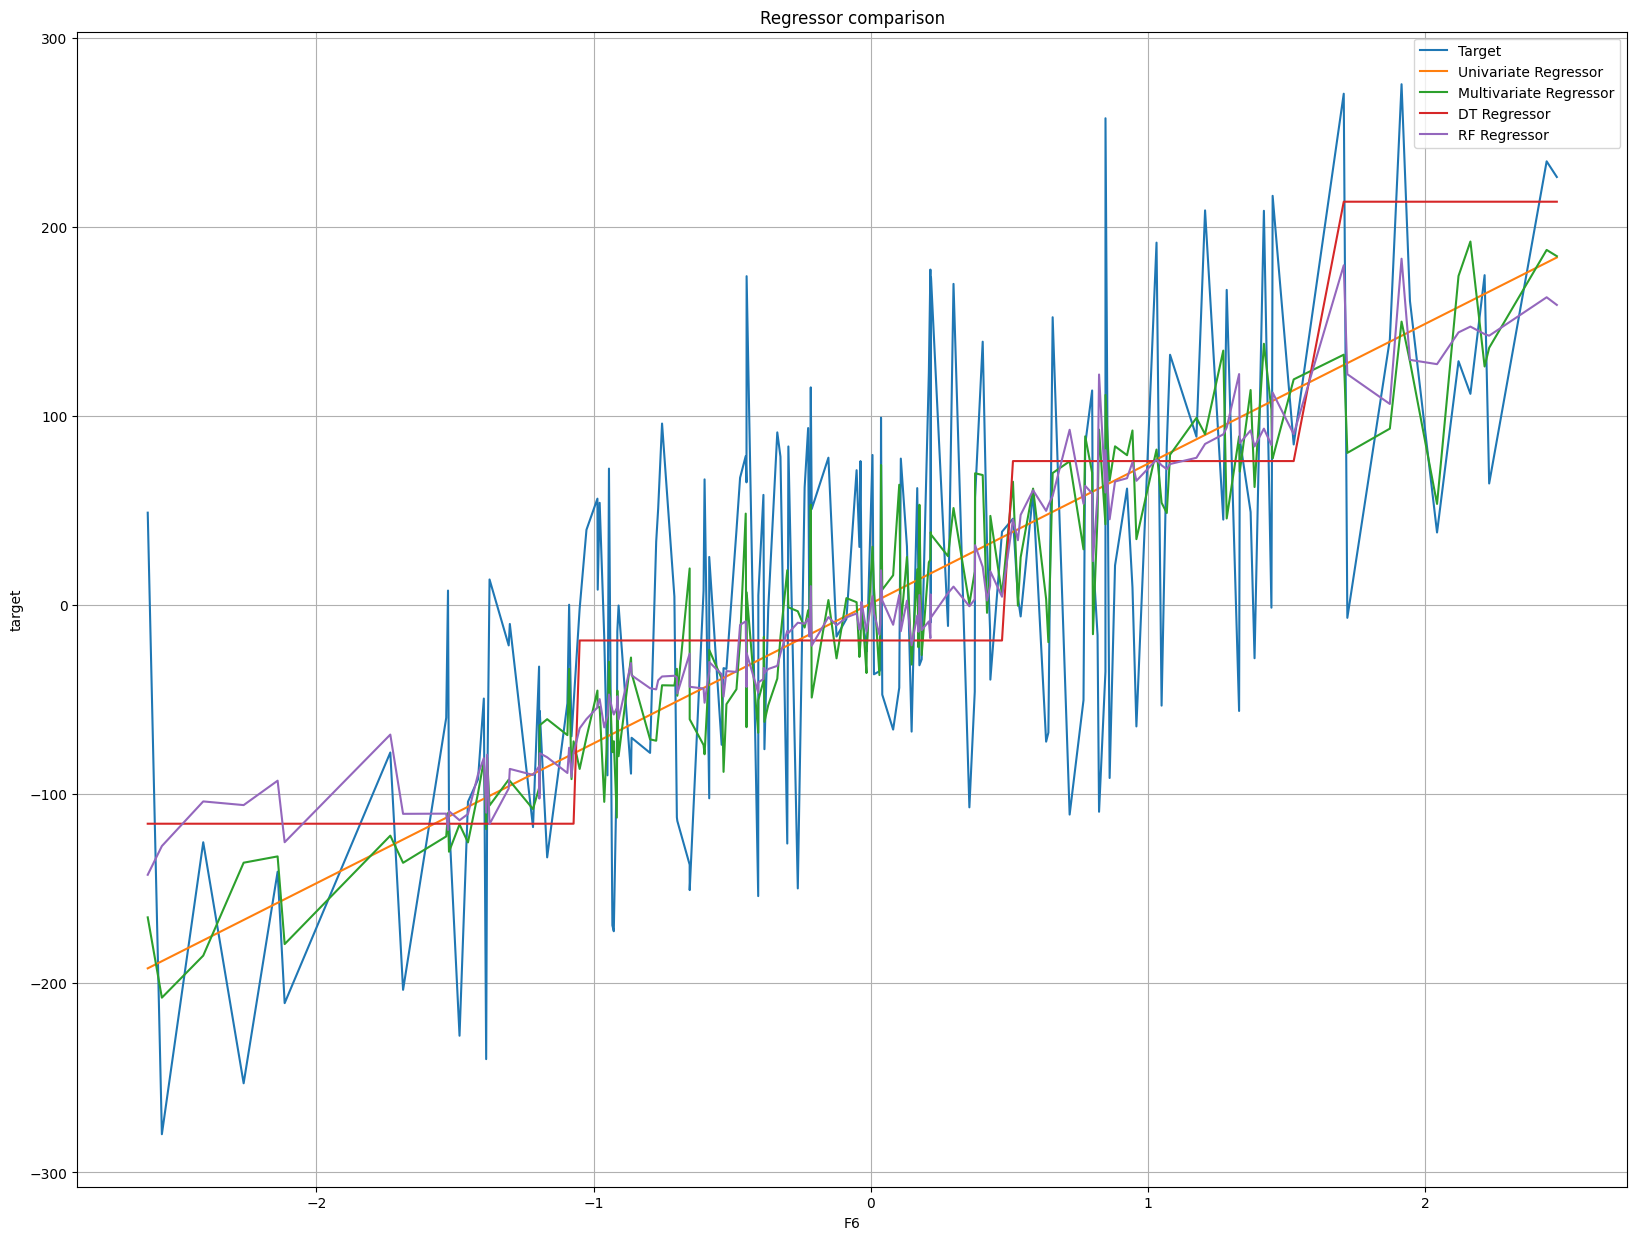

In [327]:
### Mostriamo anche il modello

import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(20,15))

plt.plot(df_test_sorted[most_correlated], df_test_sorted[target], label="Target")
plt.plot(df_test_sorted[most_correlated], df_test_sorted["uni_pred"], label="Univariate Regressor")
plt.plot(df_test_sorted[most_correlated], df_test_sorted["multi_pred"], label="Multivariate Regressor")
plt.plot(df_test_sorted[most_correlated], df_test_sorted["dt_pred"], label="DT Regressor")
plt.plot(df_test_sorted[most_correlated], df_test_sorted["rf_pred"], label="RF Regressor")
plt.xlabel(most_correlated)
plt.ylabel("target")
plt.title("Regressor comparison")
plt.legend()
plt.grid(True)

plt.show()

In [289]:
results

# Dal grafico e dai risultati notiamo che approcci con DT non sono molto precisi (funzionano bene con valori discreti)
# L'approccio migliore è quello Multivariato, dato che usare tutti i predictors da sicuramente delle informazioni in più rispetto al caso univariato

,Model,RMSE,R_square
0,Univariate,85.121744,0.338477
1,Multivariate,81.104168,0.399448
2,DT Multivariate,89.827208,0.263318
3,RF Multivariate,84.701234,0.344997


## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 

### Decision Tree and Random Forest regression
- Decision Tree and Random Forest have an RMSE slightly higher than multivariate linear regression



## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with other columns and comment the results